In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import io
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the dataset
splits = {
    'train': 'data/train-00000-of-00001-c08a401c53fe5312.parquet',
    'test': 'data/test-00000-of-00001-44110b9df98c5585.parquet'
}

df = pd.read_parquet("hf://datasets/Falah/Alzheimer_MRI/" + splits["train"])

# Label mapping
label_mapping = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}

# Image Preprocessing Function
def preprocess_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")  # Convert to RGB
    image = image.resize((128, 128))  # Resize to 128x128 (saves RAM)
    return np.array(image) / 255.0  # Normalize pixels

# Create generators to load images dynamically
def data_generator(df, batch_size=16):
    while True:
        for i in range(0, len(df), batch_size):
            batch = df.iloc[i:i + batch_size]
            images = np.array([preprocess_image(img['bytes']) for img in batch['image']])
            labels = np.array(batch['label'])
            yield images, labels

# Split into train & validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Create generators
batch_size = 16
train_gen = data_generator(train_df, batch_size=batch_size)
val_gen = data_generator(val_df, batch_size=batch_size)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Training samples: 4096, Validation samples: 1024


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define CNN Model (Optimized for RAM)
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 826,724 (3.15 MB)

 Trainable params: 826,724 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Train the model
steps_per_epoch = len(train_df) // batch_size
val_steps = len(val_df) // batch_size

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=10,  # Adjust as needed
    verbose=1
)

# Save the trained model
model.save("optimized_model.h5")
print("Model saved successfully!")


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 58s 219ms/step - accuracy: 0.4851 - loss: 1.0563 - val_accuracy: 0.5771 - val_loss: 0.9279
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 54s 212ms/step - accuracy: 0.5599 - loss: 0.9141 - val_accuracy: 0.6123 - val_loss: 0.8576
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 54s 213ms/step - accuracy: 0.6132 - loss: 0.8401 - val_accuracy: 0.6191 - val_loss: 0.7896
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 83s 325ms/step - accuracy: 0.6360 - loss: 0.7660 - val_accuracy: 0.6631 - val_loss: 0.7234
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 55s 216ms/step - accuracy: 0.6884 - loss: 0.6724 - val_accuracy: 0.7305 - val_loss: 0.5568
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 83s 323ms/step - accuracy: 0.7361 - loss: 0.5564 - val_accuracy: 0.7363 - val_loss: 0.5642
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 56s 218ms/step - accuracy: 0.7830 - loss: 0.4602 - val_accuracy: 0.8135 - val_loss: 0.4392
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 81s 316ms/step - accuracy: 0.8234 - loss: 0

Model saved successfully!


In [5]:
test_df = pd.read_parquet("hf://datasets/Falah/Alzheimer_MRI/" + splits["test"])
test_gen = data_generator(test_df, batch_size=batch_size)

test_steps = len(test_df) // batch_size
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9091 - loss: 0.3050
Test Accuracy: 89.61%


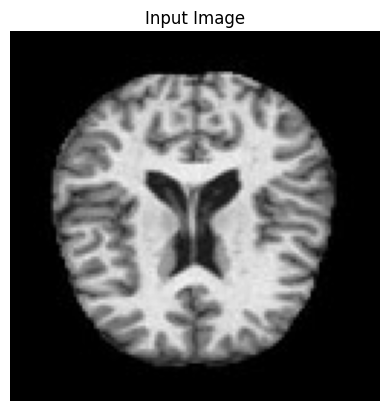

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted Label: Non_Demented


In [6]:
import matplotlib.pyplot as plt

def predict_and_display(image_bytes):
    # Preprocess the image
    image = preprocess_image(image_bytes)

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    # Add batch dimension and predict
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions)

    return label_mapping[predicted_label]

# Example usage
sample_image_bytes = test_df.iloc[2]['image']['bytes']
predicted_label = predict_and_display(sample_image_bytes)
print("Predicted Label:", predicted_label)


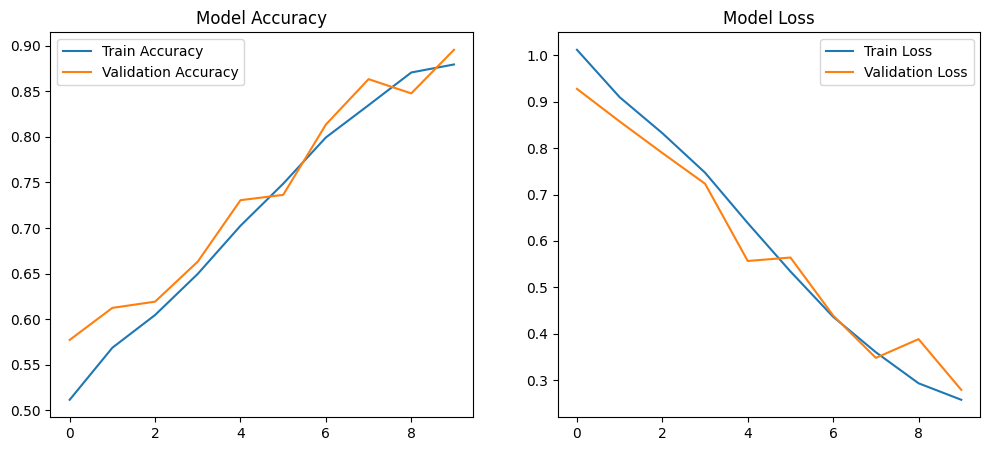

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


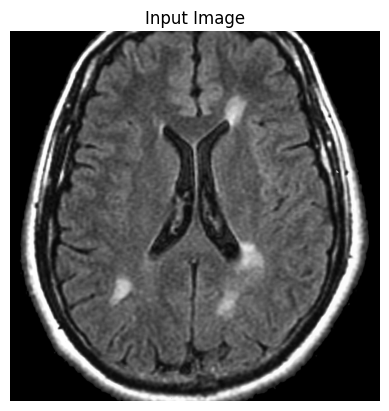

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Label: Non_Demented


In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Function to load image from a local file
def load_image_from_file(file_path):
    image = Image.open(file_path).convert("RGB")  # Convert to RGB
    return image

# Function to predict the class of the image
def predict_from_file(file_path):
    # Load image from local file
    image = load_image_from_file(file_path)

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    # Preprocess the image
    image = image.resize((128, 128))  # Resize
    image = np.array(image) / 255.0   # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions)

    return label_mapping[predicted_label]

# Example usage: Use the file path of the uploaded image
image_path = "/content/mri_4.jpeg"  # Make sure this path is correct
predicted_label = predict_from_file(image_path)
print("Predicted Label:", predicted_label)
